In [1]:
import os
import sys
import boto3
from time import time
from time import sleep
import rasterio
from rasterio.plot import show
import xarray as xr
import rioxarray

In [2]:
#! free -h

In [3]:
#!pip install rioxarray --user

In [4]:
def _xr_open_rasterio_retry(s3_file_name):
    cnt=20
    sleeptime=6
    while(cnt>0):
        try:
            da = xr.open_rasterio(s3_file_name)
            print('SUCCESS _xr_open_rasterio_retry', s3_file_name, flush=True)
            return da
        except rasterio.errors.RasterioIOError:
                        print("Unexpected error:", sys.exc_info()[0])
                        print('oops',cnt)
                        print('oops',s3_file_name, flush=True)
                        cnt = cnt - 1
                        sleep(sleeptime)

In [5]:
def xr_build_mosaic_ds(bucket, product, tifs):

    start = time()
    my_da_list =[]
    for tif in tifs:
        try:
            da = _xr_open_rasterio_retry(f's3://{bucket}/'+tif)
        except:
            print('error on ', tif, flush=True)
            print('FATAL error on ', tif, flush=True)

        try:
            da = da.squeeze().drop(labels='band')
            da.name=product
            my_da_list.append(da)
            tnow = time()
            elapsed = tnow - start
            print(tif, elapsed)
        except:
            print('FATAL SQUEEZE error on ', tif, flush=True)

    try:
        DS = xr.merge(my_da_list)
        return(DS)
    except:
        print('FATAL MERGE error on ', tif, flush=True)

In [6]:
def s3_push_delete_local(local_file, bucket, bucket_filepath):
        out_bucket = return_my_bucket(bucket_filepath)
        a = bucket_filepath.split('/')
        bucket_filepath = '/'.join(a[1:]) # strip bucket from path
        print('PUSH', out_bucket, bucket_filepath)
        s3 = boto3.client('s3')
        with open(local_file, "rb") as f:
            s3.upload_fileobj(f, out_bucket, bucket_filepath)
        os.remove(local_file)

In [7]:
def _run_command(cmd, verbose=False):
    if verbose:
        print(cmd)
    result = os.system(cmd)
    if result != 0:
        raise Exception('command "%s" failed with code %d.' % (cmd, result))

In [8]:
def cog_create_from_tif(src_tif,dst_cog):
    command = f'rio cogeo create {src_tif} {dst_cog}'
    _run_command(command)

In [9]:
def return_my_bucket(prefix_with_slash):
    a = prefix_with_slash.split('/')
    print('a=',a)
    THE_BUCKET=a[0]
    print("the BUCKET=",THE_BUCKET)
    return THE_BUCKET

In [10]:
def xr_write_geotiff_from_ds(DS, primary_name, out_prefix_path):
    
    print(DS) # DS is the xarray
    print(primary_name) # first tif 
    print(out_prefix_path)

    a = primary_name.split('/')
    just_tif = a[-2] + '/' + a[-1]
    local_tif = a[-1]
    local_cog = 'COG_' + local_tif

    output = out_prefix_path + just_tif
    bucket = 'ws-enduser'
    print(f'OUTPUT=={output}')
    DS.rio.to_raster(local_tif)
    cog_create_from_tif(local_tif, local_cog)
    s3_push_delete_local(local_cog, bucket, output)
    os.remove(local_tif)
    local_xml = local_cog + '.aux.xml'
    os.remove(local_xml)

In [11]:
bucket = 'ws-enduser'
product = 'etasw'
tifs = ['USA/r37.0_tile0/2000/etasw_200001.tif',
        'USA/r37.0_tile1/2000/etasw_200001.tif',
        'USA/r37.0_tile2/2000/etasw_200001.tif',
        'USA/r37.0_tile3/2000/etasw_200001.tif',
        'USA/r50.0_tile5/2000/etasw_200001.tif']

# ,
#         'USA/r50.0_tile6/2000/etasw_200001.tif',
#         'USA/r50.0_tile7/2000/etasw_200001.tif',
#         'USA/r50.0_tile8/2000/etasw_200001.tif',
#         'USA/r50.0_tile9/2000/etasw_200001.tif']

In [12]:
# s3_file_name = 's3://ws-enduser/USA/r37.0_tile0/2000/etasw_200001.tif'
# da = xr.open_rasterio(s3_file_name)
# da

In [13]:
DS = xr_build_mosaic_ds(bucket, product, tifs)

SUCCESS _xr_open_rasterio_retry s3://ws-enduser/USA/r37.0_tile0/2000/etasw_200001.tif
USA/r37.0_tile0/2000/etasw_200001.tif 0.4861021041870117
SUCCESS _xr_open_rasterio_retry s3://ws-enduser/USA/r37.0_tile1/2000/etasw_200001.tif
USA/r37.0_tile1/2000/etasw_200001.tif 0.6597459316253662
SUCCESS _xr_open_rasterio_retry s3://ws-enduser/USA/r37.0_tile2/2000/etasw_200001.tif
USA/r37.0_tile2/2000/etasw_200001.tif 0.8233506679534912
SUCCESS _xr_open_rasterio_retry s3://ws-enduser/USA/r37.0_tile3/2000/etasw_200001.tif
USA/r37.0_tile3/2000/etasw_200001.tif 0.9681954383850098
SUCCESS _xr_open_rasterio_retry s3://ws-enduser/USA/r50.0_tile5/2000/etasw_200001.tif
USA/r50.0_tile5/2000/etasw_200001.tif 1.2238576412200928


In [14]:
DS

<xarray.Dataset>
Dimensions:  (x: 24998, y: 12976)
Coordinates:
  * x        (x) float64 -125.0 -125.0 -125.0 -125.0 ... -73.0 -73.0 -73.0
  * y        (y) float64 23.0 23.0 23.0 23.01 23.01 ... 49.99 49.99 50.0 50.0
Data variables:
    etasw    (y, x) float64 -7.846e+39 -7.846e+39 -7.846e+39 ... nan nan nan
Attributes:
    transform:           (0.0020803384719955188, 0.0, -125.00034453048596, 0....
    crs:                 +init=epsg:4326
    res:                 (0.0020803384719955188, -0.0020810045000000006)
    is_tiled:            1
    nodatavals:          (nan,)
    scales:              (1.0,)
    offsets:             (0.0,)
    descriptions:        ('etasw_',)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

In [15]:
# DS = xr_build_mosaic_ds(bucket, product, tifs)
primary_name = tifs[0]  #first tif in list
out_prefix_path = 'ws-enduser/USA/conus_mos/' # it gets the "year" folder from the function

xr_write_geotiff_from_ds(DS, primary_name, out_prefix_path)

<xarray.Dataset>
Dimensions:  (x: 24998, y: 12976)
Coordinates:
  * x        (x) float64 -125.0 -125.0 -125.0 -125.0 ... -73.0 -73.0 -73.0
  * y        (y) float64 23.0 23.0 23.0 23.01 23.01 ... 49.99 49.99 50.0 50.0
Data variables:
    etasw    (y, x) float64 -7.846e+39 -7.846e+39 -7.846e+39 ... nan nan nan
Attributes:
    transform:           (0.0020803384719955188, 0.0, -125.00034453048596, 0....
    crs:                 +init=epsg:4326
    res:                 (0.0020803384719955188, -0.0020810045000000006)
    is_tiled:            1
    nodatavals:          (nan,)
    scales:              (1.0,)
    offsets:             (0.0,)
    descriptions:        ('etasw_',)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST
USA/r37.0_tile0/2000/etasw_200001.tif
ws-enduser/USA/conus_mos/
OUTPUT==ws-enduser/USA/conus_mos/2000/etasw_200001.tif
a= ['ws-enduser', 'USA', 'conus_mos', '2000', 'etasw_200001.tif']
the BUCKET= ws-enduser
PUSH ws-enduser USA/conus_mos/2000/etasw_200001.tif


In [16]:
! aws s3 ls s3://ws-enduser/USA/conus_mos/2000/

2021-08-27 12:37:39 1035111402 etasw_200001.tif


In [17]:
! rio info s3://ws-enduser/USA/conus_mos/2000/etasw_200001.tif

{"blockxsize": 512, "blockysize": 512, "bounds": [-125.0003444888742, 50.0000022172222, -72.99812378762573, 22.9989689901079], "colorinterp": ["gray"], "compress": "deflate", "count": 1, "crs": "EPSG:4326", "descriptions": ["etasw"], "driver": "GTiff", "dtype": "float64", "height": 12976, "indexes": [1], "interleave": "band", "lnglat": [-98.99923413824996, 36.49948560366505], "mask_flags": [["nodata"]], "nodata": NaN, "res": [0.0020802552484698164, -0.0020808441142967245], "shape": [12976, 24998], "tiled": true, "transform": [0.0020802552484698164, 0.0, -125.0003444888742, 0.0, 0.0020808441142967245, 22.9989689901079, 0.0, 0.0, 1.0], "units": [null], "width": 24998}


In [18]:
! rio info s3://ws-enduser/USA/conus_mos/2000/etasw_200001.tif | python -m json.tool

{
    "blockxsize": 512,
    "blockysize": 512,
    "bounds": [
        -125.0003444888742,
        50.0000022172222,
        -72.99812378762573,
        22.9989689901079
    ],
    "colorinterp": [
        "gray"
    ],
    "compress": "deflate",
    "count": 1,
    "crs": "EPSG:4326",
    "descriptions": [
        "etasw"
    ],
    "driver": "GTiff",
    "dtype": "float64",
    "height": 12976,
    "indexes": [
        1
    ],
    "interleave": "band",
    "lnglat": [
        -98.99923413824996,
        36.49948560366505
    ],
    "mask_flags": [
        [
            "nodata"
        ]
    ],
    "nodata": NaN,
    "res": [
        0.0020802552484698164,
        -0.0020808441142967245
    ],
    "shape": [
        12976,
        24998
    ],
    "tiled": true,
    "transform": [
        0.0020802552484698164,
        0.0,
        -125.0003444888742,
        0.0,
        0.0020808441142967245,
        22.9989689901079,
        0.0,
        0.0,
        1.0
    ],
    "units": [
  

In [19]:
#! gdalinfo /vsis3/ws-enduser/USA/conus_mos/2000/2000/etasw_200001.tif - not working yet

### open geoTIFF from an amazon data bucket

In [20]:
s3_file = 's3://ws-enduser/USA/conus_mos/2000/etasw_200001.tif'

In [21]:
with rasterio.open(s3_file) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': nan, 'width': 24998, 'height': 12976, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0020802552484698164, 0.0, -125.0003444888742,
       0.0, 0.0020808441142967245, 22.9989689901079), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


{'driver': 'GTiff', 'dtype': 'float64', 'nodata': nan, 'width': 24998, 'height': 12976, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0020802552484698164, 0.0, -125.0003444888742,
       0.0, 0.0020808441142967245, 22.9989689901079), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


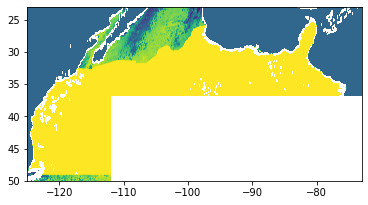

[[-7.84563485e+39 -7.84563485e+39 -7.84563485e+39 ... -7.84563485e+39
  -7.84563485e+39 -7.84563485e+39]
 [-7.84563485e+39 -7.84563485e+39 -7.84563485e+39 ... -7.84563485e+39
  -7.84563485e+39 -7.84563485e+39]
 [-7.84563485e+39 -7.84563485e+39 -7.84563485e+39 ... -7.84563485e+39
  -7.84563485e+39 -7.84563485e+39]
 ...
 [-7.84563485e+39 -7.84563485e+39 -7.84563485e+39 ...             nan
              nan             nan]
 [-7.84563485e+39 -7.84563485e+39 -7.84563485e+39 ...             nan
              nan             nan]
 [-7.84563485e+39 -7.84563485e+39 -7.84563485e+39 ...             nan
              nan             nan]]


In [22]:
with rasterio.open(s3_file) as src:
    print(src.profile)
    show(src)
    array=src.read(1)
print(array)